In [2]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from fl_bench.networks.chest_nets import *
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
model_list = [
    resnet_50_supervised, 
    resnet50_gn_supervised,
    seresnet_50_supervised,
    nf_resnet50_supervised,
    anfr_resnet50_pretrained
]
common = # path to the global model
path_list = [
    "chest/resnet_50_supervised" + common,
    "chest/resnet50_gn_supervised" + common,
    "chest/seresnet_50_supervised" + common,
    "chest/nf_resnet50_supervised" + common,
    "chest/anfr_resnet50_pretrained" + common
]
layer_list = [
    "layer4[-1]",
    "layer4[-1]",
    "layer4[-1]",
    "stages[3][-1]",
    "stages[3][-1]"
]
cls_mapping = {
    "Atelectasis": 0,
    "Cardiomegaly": 1,
    "Consolidation": 2,
    "Edema": 3,
    "Effusion": 4,
    "No Finding": 5,
    "Pneumonia": 6,
    "Pneumothorax": 7
}
# We'll use CXR14 images for which we have bboxes
import pandas as pd
bbox_dict = {}
cxr_path= # path to the dataset
bbox = pd.read_csv(cxr_path+"BBox_List_2017.csv")
test_data = pd.read_csv(cxr_path+"cxr14_test.csv")
test_with_bbox = []
for i in range(len(bbox)):
    if bbox.iloc[i, 0] in test_data['Path'].values:
        test_with_bbox.append(bbox.iloc[i, 0])

# check against the test data to find those that only have 1 finding
image_list = []
for name in test_with_bbox:
    if test_data[test_data['Path']==name].iloc[0, 3:].sum() == 1:
        image_list.append(name)


for name in image_list:
    im = Image.open(cxr_path+"images/" + name)
    box = bbox[bbox['Image Index'] == name]
    width = box["w"].values[0]
    height = box['h]'].values[0]
    x = box['Bbox [x'].values[0]
    y = box["y"].values[0]

    # resize the image to 224x224 and
    # use the image width and height to scale the bounding box coordinates
    im_w, im_h = im.size
    im = im.resize((224, 224))
    x = x / im_w * 224
    y = y / im_h * 224
    width = width / im_w * 224
    height = height / im_h * 224
    # normalize the image
    im = np.array(im)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0)
    im = np.stack([im[:,:], im[:,:], im[:,:]], axis=2)

    bbox_dict[name] = {
        "image": im,
        "tensor": tensor,
        "label": box["Finding Label"].values[0],
        "bbox": [x, y, width, height]
    }

# remove any entries in bbox_dict that don't have a label in cls_mapping
for key in list(bbox_dict.keys()):
    if bbox_dict[key]['label'] not in cls_mapping:
        del bbox_dict[key]

In [3]:
len(bbox_dict)

25

In [4]:
for i, (model, path, layer) in enumerate(zip(model_list, path_list, layer_list)):
    model = model(1).to("cuda")
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'])
    target_layers = [eval(f"model.{layer}")]


    with GradCAMPlusPlus(model=model, target_layers=target_layers) as gradcam:
        
        for k,v in bbox_dict.items():
            input_tensor = v['tensor'].float()
            image = v['image']
            targets = [ClassifierOutputTarget(cls_mapping[v['label']])]
            grayscale_cam = gradcam(
                input_tensor=input_tensor, 
                targets=targets, 
                eigen_smooth=False,
                aug_smooth=False
            )
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
            bbox_dict[k][f'gradcam_{i}'] = visualization


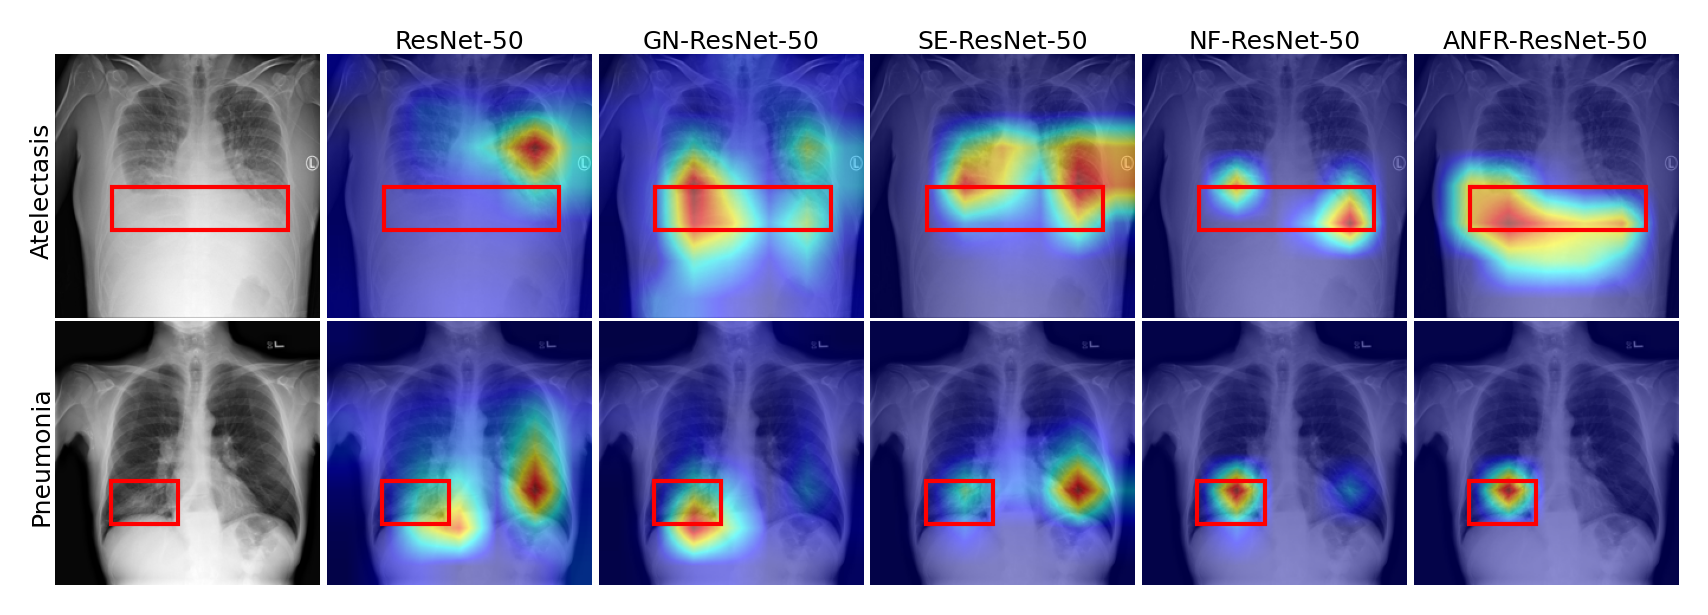

In [5]:
# in a 4 column grid, show the original image with the bounding box, and the gradcam for each model, with the bounding box
fig, ax = plt.subplots(2, 6, figsize=(7, 2.3), dpi=300)
# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)
plt.margins(x=0, y=0)
# plt.tight_layout(pad=0.00)
idx=0
for i, (k, v) in enumerate(bbox_dict.items()):
    if i not in [0,21]:
        continue
    ax[idx, 0].imshow(v['image'])
    ax[idx, 0].add_patch(patches.Rectangle((v['bbox'][0], v['bbox'][1]), v['bbox'][2], v['bbox'][3], linewidth=1, edgecolor='r', facecolor='none'))
    ax[idx, 0].set_title(v['label'], fontsize=6,rotation='vertical',x=-0.05,y=0.15,)
    ax[idx, 0].axis("off")

    ax[idx, 1].imshow(v['gradcam_0'])
    ax[idx, 1].add_patch(patches.Rectangle((v['bbox'][0], v['bbox'][1]), v['bbox'][2], v['bbox'][3], linewidth=1, edgecolor='r', facecolor='none'))
    ax[idx, 1].set_title("ResNet-50", fontsize=6, pad=0) if idx == 0 else None
    ax[idx, 1].axis("off")

    ax[idx, 2].imshow(v['gradcam_1'])
    ax[idx, 2].add_patch(patches.Rectangle((v['bbox'][0], v['bbox'][1]), v['bbox'][2], v['bbox'][3], linewidth=1, edgecolor='r', facecolor='none'))
    ax[idx, 2].set_title("GN-ResNet-50", fontsize=6, pad=0) if idx == 0 else None
    ax[idx, 2].axis("off")

    ax[idx, 3].imshow(v['gradcam_2'])
    ax[idx, 3].add_patch(patches.Rectangle((v['bbox'][0], v['bbox'][1]), v['bbox'][2], v['bbox'][3], linewidth=1, edgecolor='r', facecolor='none'))
    ax[idx, 3].set_title("SE-ResNet-50", fontsize=6, pad=0) if idx == 0 else None
    ax[idx, 3].axis("off")

    ax[idx, 4].imshow(v['gradcam_3'])
    ax[idx, 4].add_patch(patches.Rectangle((v['bbox'][0], v['bbox'][1]), v['bbox'][2], v['bbox'][3], linewidth=1, edgecolor='r', facecolor='none'))
    ax[idx, 4].set_title("NF-ResNet-50", fontsize=6, pad=0) if idx == 0 else None
    ax[idx, 4].axis("off")

    ax[idx, 5].imshow(v['gradcam_4'])
    ax[idx, 5].add_patch(patches.Rectangle((v['bbox'][0], v['bbox'][1]), v['bbox'][2], v['bbox'][3], linewidth=1, edgecolor='r', facecolor='none'))
    ax[idx, 5].set_title("ANFR-ResNet-50", fontsize=6, pad=0) if idx == 0 else None
    ax[idx, 5].axis("off")
    idx +=1
# save without margins
plt.savefig("gradcam_comparison.png", bbox_inches='tight', pad_inches=0)